# FiPy Hackathon 1

The problems for hackathon 1 are given [here]({{ site.baseurl }}/hackathon1/#Challange-Problems).

## 1. Spinodal Decomposition

The free energy is given by,

$$ f_0\left[ c \left( \vec{r} \right) \right] =
   - \frac{A}{2} \left(c - c_m\right)^2
   + \frac{B}{4} \left(c - c_m\right)^4
   + \frac{c_{\alpha}}{4} \left(c - c_{\alpha} \right)^4
   + \frac{c_{\beta}}{4} \left(c - c_{\beta} \right)^4 $$

In FiPy we write the evolution equation as 

$$ \frac{\partial c}{\partial t} = \nabla \cdot  \left[
       D \left( c \right) \left( \frac{ \partial^2 f_0 }{ \partial c^2} \nabla c - \kappa \nabla \nabla^2 c \right)
   \right] $$

Let's start by calculating $ \frac{ \partial^2 f_0 }{ \partial c^2} $ using sympy. It's easy for this case, but useful in the general case for taking care of difficult book keeping in phase field problems.

In [25]:
%matplotlib inline

import sympy
import fipy as fp
import numpy as np

In [26]:
A, c, c_m, B, c_alpha, c_beta = sympy.symbols("A c_var c_m B c_alpha c_beta")

In [27]:
f_0 = - A / 2 * (c - c_m)**2 + B / 4 * (c - c_m)**4 + c_alpha / 4 * (c - c_alpha)**4 + c_beta / 4 * (c - c_beta)**4

In [28]:
print f_0

-A*(-c_m + c_var)**2/2 + B*(-c_m + c_var)**4/4 + c_alpha*(-c_alpha + c_var)**4/4 + c_beta*(-c_beta + c_var)**4/4


In [29]:
sympy.diff(f_0, c, 2)

-A + 3*B*(c_m - c_var)**2 + 3*c_alpha*(c_alpha - c_var)**2 + 3*c_beta*(c_beta - c_var)**2

The first step in implementing any problem in FiPy is to define the mesh. For [Problem 1a]({{ site.baseurl }}/hackathon1/#a.-Square-Periodic) the solution domain is just a square domain, but the boundary conditions are periodic, so a `PeriodicGrid2D` object is used. No other boundary conditions are required.

In [30]:
mesh = fp.PeriodicGrid2D(nx=50, ny=50, dx=0.5, dy=0.5)

The next step is to define the parameters and create a solution variable.

In [31]:
c_alpha = 0.05
c_beta = 0.95
A = 2.0
kappa = 2.0
c_m = (c_alpha + c_beta) / 2.
B = A / (c_alpha - c_m)**2
D = D_alpha = D_beta = 2. / (c_beta - c_alpha)
c_0 = 0.45
q = np.sqrt((2., 3.))
epsilon = 0.01

c_var = fp.CellVariable(mesh=mesh, name=r"$c$", hasOld=True)

Now we need to define the initial conditions given by,

Set $c\left(\vec{r}, t\right)$ such that

$$ c\left(\vec{r}, 0\right) = \bar{c}_0 + \epsilon \cos \left( \vec{q} \cdot \vec{r} \right) $$

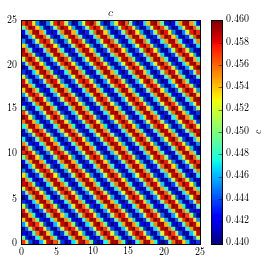

In [32]:
r = np.array((mesh.x, mesh.y))
c_var[:] = c_0 + epsilon * np.cos((q[:, None] * r).sum(0))
viewer = fp.Viewer(c_var)

### Define `f_0_var`

To define the equation with FiPy first define `f_0` in terms of FiPy. Recall `f_0` from above calculated using Sympy. Here we use the string representation and set it equal to `f_0_var` using the `exec` command.

In [37]:
out = sympy.diff(f_0, c, 2)

In [38]:
exec "f_0_var = " + repr(out)

In [39]:
#f_0_var = -A + 3*B*(c_var - c_m)**2 + 3*c_alpha*(c_var - c_alpha)**2 + 3*c_beta*(c_var - c_beta)**2
f_0_var

(((((pow((0.5 - $c$), 2)) * 29.6296296296) + -2.0) + ((pow((0.05 - $c$), 2)) * 0.15)) + ((pow((0.95 - $c$), 2)) * 2.85))

### Define the Equation

In [40]:
eqn = fp.TransientTerm(coeff=1.) == fp.DiffusionTerm(D * f_0_var) - fp.DiffusionTerm((D, kappa))
eqn

(TransientTerm(coeff=1.0) + (DiffusionTerm(coeff=[-(((((((pow((0.5 - $c$), 2)) * 29.6296296296) + -2.0) + ((pow((0.05 - $c$), 2)) * 0.15)) + ((pow((0.95 - $c$), 2)) * 2.85)) * 2.22222222222))]) + DiffusionTerm(coeff=[2.2222222222222223, 2.0])))

### Solve the Equation

To solve the equation a simple time stepping scheme is used which is decreased or increased based on whether the residual decreases or increases. A time step is recalculated if the required tolerance is not reached.

In [50]:
elapsed = 0.0
steps = 0
dt = 0.01
total_sweeps = 2
tolerance = 1e-1
total_steps = 100

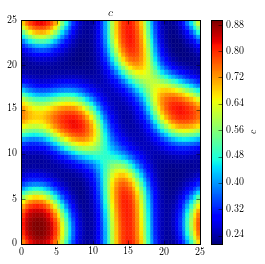

elapsed_time: 28.1146704521


In [51]:
c_var[:] = c_0 + epsilon * np.cos((q[:, None] * r).sum(0))
c_var.updateOld()
from fipy.solvers.pysparse import LinearLUSolver as Solver
solver = Solver()

while elapsed < duration and steps < total_steps:
    res0 = eqn.sweep(c_var, dt=dt, solver=solver)

    for sweeps in range(total_sweeps):
        res = eqn.sweep(c_var, dt=dt, solver=solver)

    if res < res0 * tolerance:
        steps += 1
        elapsed += dt
        dt *= 1.1
        c_var.updateOld()
    else:
        dt *= 0.8
        c_var[:] = c_var.old

viewer.plot()
print 'elapsed_time:',elapsed

### Run the Example Locally

The following cell will dumpy a file called `fipy_hackathon1a.py` to the local file system to be run. The images are saved out at each time step.

In [53]:
%%writefile fipy_hackathon_1a.py

import fipy as fp
import numpy as np

mesh = fp.PeriodicGrid2D(nx=400, ny=400, dx=0.5, dy=0.5)

c_alpha = 0.05
c_beta = 0.95
A = 2.0
kappa = 2.0
c_m = (c_alpha + c_beta) / 2.
B = A / (c_alpha - c_m)**2
D = D_alpha = D_beta = 2. / (c_beta - c_alpha)
c_0 = 0.45
q = np.sqrt((2., 3.))
epsilon = 0.01

c_var = fp.CellVariable(mesh=mesh, name=r"$c$", hasOld=True)

r = np.array((mesh.x, mesh.y))
c_var[:] = c_0 + epsilon * np.cos((q[:, None] * r).sum(0))

f_0_var = -A + 3*B*(c_var - c_m)**2 + 3*c_alpha*(c_var - c_alpha)**2 + 3*c_beta*(c_var - c_beta)**2

eqn = fp.TransientTerm(coeff=1.) == fp.DiffusionTerm(D * f_0_var) - fp.DiffusionTerm((D, kappa))

elapsed = 0.0
steps = 0
dt = 0.01
total_sweeps = 2
tolerance = 1e-1
total_steps = 300

c_var[:] = c_0 + epsilon * np.cos((q[:, None] * r).sum(0))

c_var.updateOld()

from fipy.solvers.pysparse import LinearLUSolver as Solver

solver = Solver()

viewer = fp.Viewer(c_var)
while steps < total_steps:
    res0 = eqn.sweep(c_var, dt=dt, solver=solver)

    for sweeps in range(total_sweeps):
        res = eqn.sweep(c_var, dt=dt, solver=solver)

        print ' '
        print 'steps',steps
        print 'res',res
        print 'sweeps',sweeps
        print 'dt',dt


    if res < res0 * tolerance:
        steps += 1
        elapsed += dt
        dt *= 1.1
        if steps % 1 == 0:
             viewer.plot('image{0}.png'.format(steps))
        c_var.updateOld()
    else:
        dt *= 0.8
        c_var[:] = c_var.old

Overwriting fipy_hackathon_1a.py
